# Cheat sheet - Simple Moving Average cross over

### by François Goujon

When the short term moving average crosses above the long term moving average, this indicates a buy signal.

Contrary, when the short term moving average crosses below the long term moving average, it may be a good moment to sell.

### Imports

In [137]:
from datetime import date
import seaborn
import matplotlib.pyplot as plt
import yfinance as yf

### Functions

In [236]:
def get_data(ticker):
    df = yf.Ticker(ticker).history(period="5y")
    df.index = df.index.to_series().dt.date
    return df

def plot_price(data):
    data["Close"].plot(figsize=(12,6))
    plt.grid()
    plt.ylabel("Price")
    plt.show()
    
def add_sma(data, days):
    col_name = "SMA_" + str(days)
    data[col_name] = data["Close"].rolling(window = days, min_periods = 1).mean()
    
def add_ema(data, days):
    col_name = "EMA_" + str(days) 
    data[col_name] = data["Close"].ewm(span = days, adjust = False).mean()
    
def add_signal(data, ma_short, ma_long, ma = "SMA"):
    ma_short_label = ma + "_" + str(ma_short)
    ma_long_label = ma + "_" + str(ma_long)
    label_stlt = "STOverLT_" + ma
    label_pos = "Position_" + ma
    data[label_stlt] = np.where(data[ma_short_label] > data[ma_long_label], 1.0, 0.0)
    data[label_pos] = data[label_stlt].diff()
    
def plot_mas(data, ma = "SMA", show = True):
    cols = ["Close"]
    for c in data.columns:
        if ma+"_" in c:
            cols.append(c)
    data[cols].plot(figsize=(12,6))
    plt.grid()
    plt.ylabel("Price")
    if show:
        plt.show()
        
def plot_signal(data, ma = "SMA"):
    label_pos = "Position_" + ma
    plot_mas(data, ma, False)
    # Buy signal
    buy_idx = data[data[label_pos] == 1].index
    buy_pr = data["Close"][data[label_pos] == 1]
    plt.plot(buy_idx, buy_pr, "^", markersize = 15, color = 'g', alpha = 0.7, label = 'buy')
    # Sell signal
    sell_idx = data[data[label_pos] == -1].index
    sell_pr = data["Close"][data[label_pos] == -1]
    plt.plot(sell_idx, sell_pr, "^", markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
    plt.legend()
    plt.title(ma + " crossover")
    plt.show()
    
def signal_table(data, ma = "SMA"):
    label_pos = "Position_" + ma
    df_pos = data[["Close", label_pos]][(data[label_pos] == 1) | (data[label_pos] == -1)]
    df_pos[label_pos] = df_pos[label_pos].apply(lambda x: 'Buy' if x == 1 else 'Sell')
    display(df_pos)
    
def ma_analysis(ticker, short, long, ma = 'both'):
    b_sma, b_ema = False, False
    if ma == "both":
        b_sma, b_ema = True, True
    elif ma == "SMA":
        b_sma = True
    elif ma == "EMA":
        b_ema = True
        
    d = get_data(ticker)
    # SMA
    if b_sma:
        add_sma(d, short)
        add_sma(d, long)
        add_signal(d, short, long, "SMA")
    # EMA
    if b_ema:
        add_ema(d, short)
        add_ema(d, long)
        add_signal(d, short, long, "EMA")
    # Plots
    if b_sma:
        plot_signal(d, "SMA")
    if b_ema:
        plot_signal(d, "EMA")
    return d
    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

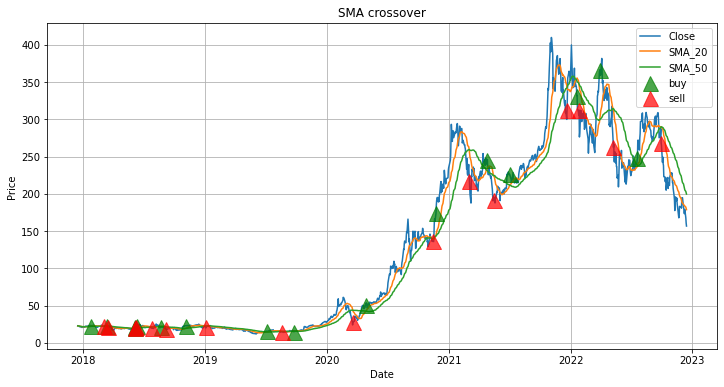

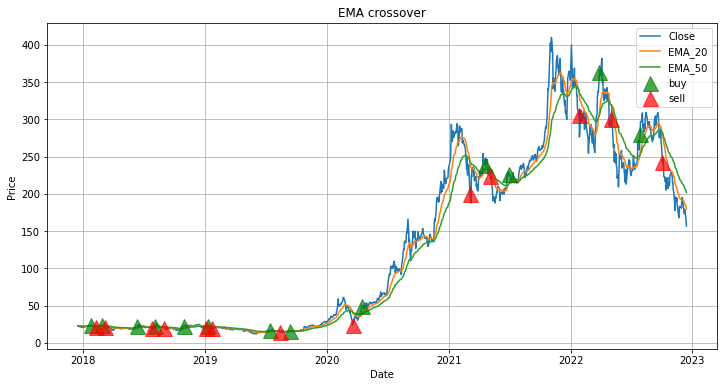

In [237]:
d = ma_analysis("TSLA", 20, 50)

In [238]:
signal_table(d, "EMA")

,Close,Position_EMA
Date,,
2018-01-23,23.519333,Buy
2018-02-09,20.694668,Sell
2018-02-26,23.827999,Buy
2018-03-06,21.879999,Sell
2018-06-11,22.139999,Buy
2018-07-26,20.443333,Sell
2018-08-03,23.211332,Buy
2018-08-30,20.209999,Sell
2018-10-31,22.488001,Buy


In [239]:
# Access a row
d.loc[date(2019, 12, 18)] 

Open            2.537533e+01
High            2.634800e+01
Low             2.537200e+01
Close           2.621000e+01
Volume          2.118150e+08
Dividends       0.000000e+00
Stock Splits    0.000000e+00
SMA_20          2.316573e+01
SMA_50          2.139367e+01
STOverLT_SMA    1.000000e+00
Position_SMA    0.000000e+00
EMA_20          2.346346e+01
EMA_50          2.160049e+01
STOverLT_EMA    1.000000e+00
Position_EMA    0.000000e+00
Name: 2019-12-18, dtype: float64

### Back-testing

In [240]:
def add_daily_returns(data):
    data["D_returns"] = data["Close"].pct_change(1)
    
def compute_ma_returns(data, ma = "SMA"):
    # Keep dates where we change position
    label_pos = "Position_" + ma
    df_pos = data[["Close", label_pos]][(data[label_pos] == 1) | (data[label_pos] == -1)]
    # Compute the return for each sell (long only)
    label_ret = ma + "_returns"
    df_pos[label_ret] = df_pos["Close"].pct_change(1)
    df_pos[label_ret][df_pos[label_pos] == 1] = 0
    # Compute cumulative returns
    label_real_ret = ma + "_real_returns"
    df_pos[label_real_ret] = df_pos[label_ret] + 1
    label_cumul = ma + "_cumul_return"
    df_pos[label_cumul] = df_pos[label_real_ret].cumprod()
    return df_pos

def plot_cumul_returns(ma_returns, ma = "SMA"):
    label_cumul = ma + "_cumul_return"
    ma_returns[label_cumul].plot(figsize=(12,6))
    plt.ylabel("Cumulative return")
    plt.title(ma + " Strategy Cumulative Returns")
    plt.show()
    
def plot_daily_returns(data):
    data["D_returns"].hist(bins=30, figsize=(12,6))
    plt.ylabel("Frequency")
    plt.xlabel("Daily Returns")
    plt.show()
    
def plot_ma_returns(ma_returns, ma = "SMA"):
    label_ret = ma + "_returns"
    label_pos = "Position_" + ma
    ma_returns[label_ret][ma_returns[label_pos] == -1].hist(bins=30, figsize=(12,6))
    plt.ylabel("Frequency")
    plt.xlabel(ma + " Strategy Returns")
    plt.show()
    
def ma_bt_analysis(ticker, short, long, ma = "both"):
    d = ma_analysis(ticker, short, long, ma)
    b_sma, b_ema = False, False
    if ma == "both":
        b_sma, b_ema = True, True
    elif ma == "SMA":
        b_sma = True
    elif ma == "EMA":
        b_ema = True
    if b_sma:
        sma_ret = compute_ma_returns(d, "SMA")
        plot_cumul_returns(sma_ret, "SMA")
    if b_ema:
        ema_ret = compute_ma_returns(d, "EMA")
        plot_cumul_returns(ema_ret, "EMA")
        
# TODO : NOT ONLY LONG : LONG/SHORT
# ROLLING SHARPE RATIO
    

<IPython.core.display.Javascript object>

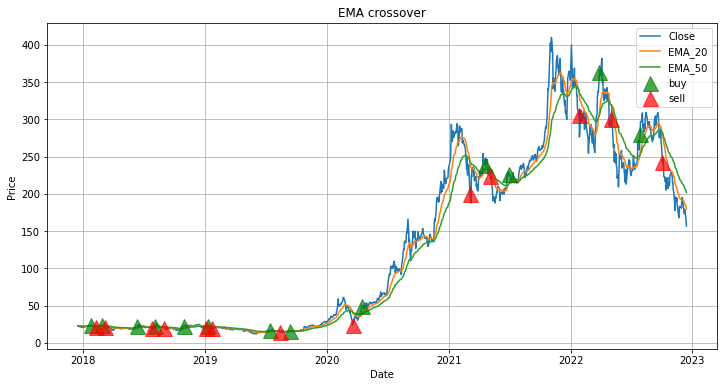

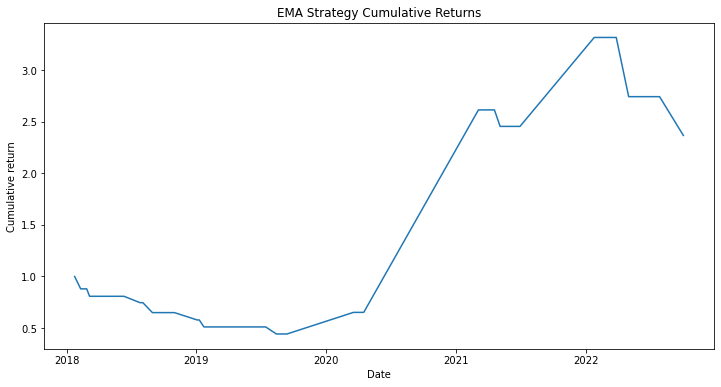

In [241]:
ma_bt_analysis("TSLA", 20, 50, "EMA")

In [242]:
add_daily_returns(d)

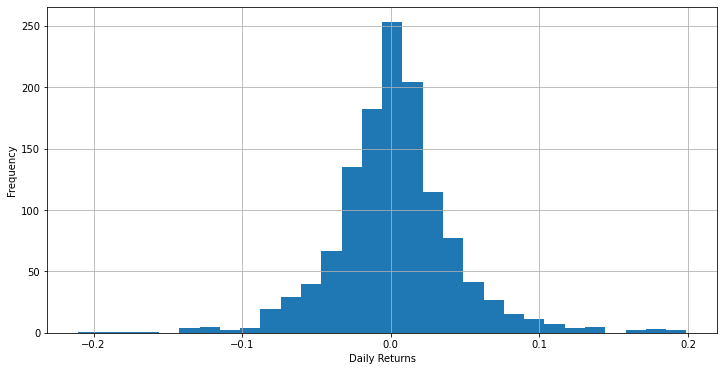

In [243]:
plot_daily_returns(d)

<IPython.core.display.Javascript object>

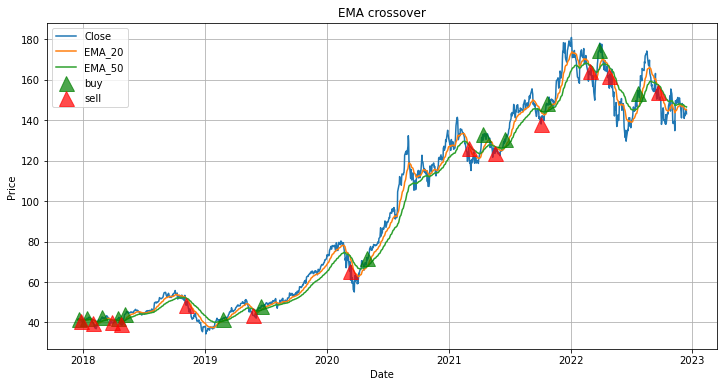

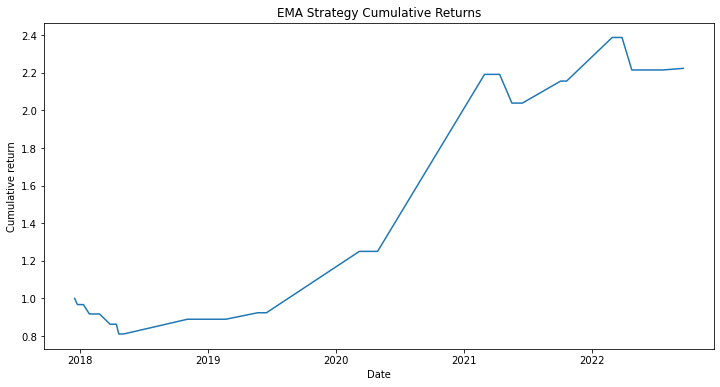

In [244]:
ma_bt_analysis("AAPL", 20, 50, "EMA")

<IPython.core.display.Javascript object>

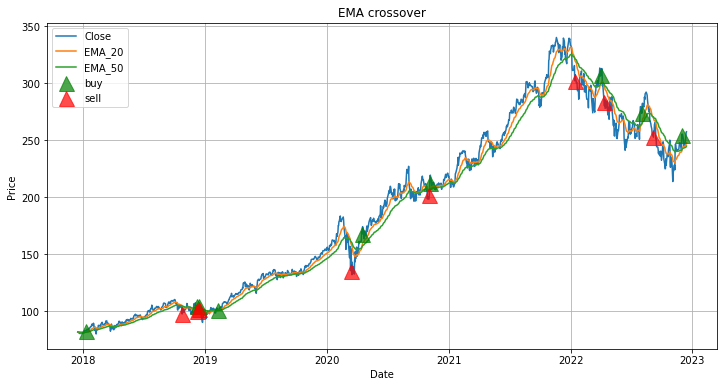

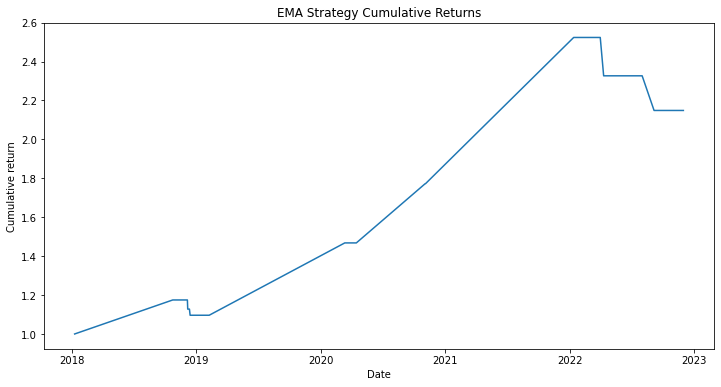

In [245]:
ma_bt_analysis("MSFT", 20, 50, "EMA")

<IPython.core.display.Javascript object>

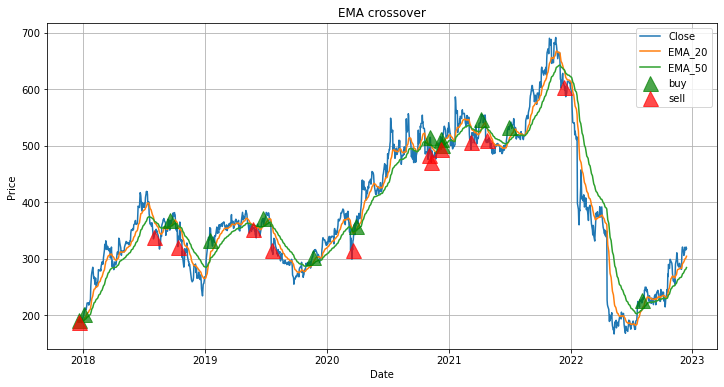

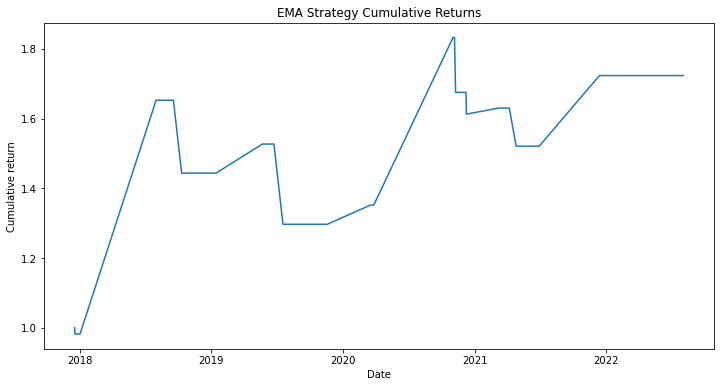

In [247]:
ma_bt_analysis("NFLX", 20, 50, "EMA")